### Extract image chip for DL using a point shapefile

#### steps
- load point file
- buffer point by chip area 
- load sen-2 data for each chip area
- extract sen-2 data for each buffered area for point
- label each image chip with point `output` attribute
- collate and export ready for DL

In [1]:
import sys

import numpy as np
import geopandas as gpd
from matplotlib import pyplot


import datacube
from datacube.utils import geometry

sys.path.append('/home/jovyan/Scripts')
from dea_datahandling import load_ard
from dea_plotting import rgb, map_shapefile
from dea_temporal import time_buffer
from dea_spatialtools import xr_rasterize


dc = datacube.Datacube(app='image chips from DEA')

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


In [2]:
# time_of_interest = '2016-06-01'
# time_buff = '180 days'
time = ('2018-01-01', '2019-01-01')

# vector_file = './extract_DLchip_by_shapefile_data/validation_comparison_ChrisO.shp'
vector_file = './extract_DLchip_by_shapefile_data/validation_comparison_Richard.shp'
attribute_col = 'index'

measurements = ['nbart_red', 'nbart_green', 'nbart_blue']
resolution = (-10, 10)
output_crs = 'EPSG:3577'
align = (0, 0)

In [3]:
gdf = gpd.read_file(vector_file)
gdf.head()

# view data on map
# map_shapefile(gdf, attribute=attribute_col)

index classified output processed                           geometry
0      0        111    111         1    POINT (334637.500 -3716937.500)
1      1        111    112         1    POINT (418462.500 -1352512.500)
2      2        111    111         1  POINT (-1220062.500 -3587637.500)
3      3        111    111         1   POINT (1697537.500 -3550887.500)
4      4        111    112         1   POINT (1179237.500 -3641187.500)

In [4]:
# change geometry in gdf to polygon buffered by XX meters and then smallest bounding box around buffered area
# 495 == chips 100 x 100
gdf['geometry'] = gdf.geometry.buffer(495).envelope

In [5]:
# query = {'time': time_buffer(time_of_interest, buffer=time_buff),
query = {'time': time,
         'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs
        }
query

{'time': ('2018-01-01', '2019-01-01'),
 'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
 'resolution': (-10, 10),
 'output_crs': 'EPSG:3577'}

In [6]:
# Dictionary to save results
CTV = []
NTV = []
NAV = []
AS = []
BS = []
W = []

# Loop through polygons in geodataframe and extract satellite data then append to relevant list
for index, row in gdf.iterrows():

    print(f'Feature: {index + 1}/{len(gdf)}')

    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Load  Sentinel-2 ARD
    ds = load_ard(dc=dc,
              products=["s2a_ard_granule", "s2b_ard_granule"],
              min_gooddata=0.99,  # only take uncloudy scenes
              group_by='solar_day',
              **query)

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    # get as numpy array
    da = ds.to_array()
    # change all Nan to 0 values (good ML practise)
    da = da.fillna(value=0)
    da_vals = da.values

    # Append results to a relevant dictionary using the output
    print(str(row['output']))
    if (str(row['output'])) == '111':
        CTV.append(da_vals)
    elif (str(row['output'])) == '112':
        NTV.append(da_vals)
    elif (str(row['output'])) == '124':
        NAV.append(da_vals)
    elif (str(row['output'])) == '215':
        AS.append(da_vals)
    elif (str(row['output'])) == '216':
        BS.append(da_vals)
    elif (str(row['output'])) == '220':
        W.append(da_vals)


Feature: 1/144
Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 25 out of 69 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 25 time steps
111
Feature: 2/144
Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 25 out of 67 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 25 time steps
112
Feature: 3/144
Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 68 out of 139 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 68 time steps
111
Feature: 4/144
Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 42 out of 69 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud ma

In [7]:
# Concatenate lists to make class data arrays
# change axis so that shape = (sample, x, y, no. of bands)
if len(CTV) > 0:
    CTV_data = np.concatenate(CTV, axis=1)
    CTV_data = np.moveaxis(CTV_data, 0, -1)
else:
    print('No data present for CTV')

if len(NTV) > 0:
    NTV_data = np.concatenate(NTV, axis=1)
    NTV_data = np.moveaxis(NTV_data, 0, -1)
else:
    print('No data present for NTV')

if len(NAV) > 0:
    NAV_data = np.concatenate(NAV, axis=1)
    NAV_data = np.moveaxis(NAV_data, 0, -1)
else:
    print('No data present for NAV')
    
if len(AS) > 0:
    AS_data = np.concatenate(AS, axis=1)
    AS_data = np.moveaxis(AS_data, 0, -1)
else:
    print('No data present for AS')
    
if len(BS) > 0:
    BS_data = np.concatenate(BS, axis=1)
    BS_data = np.moveaxis(BS_data, 0, -1)
else:
    print('No data present for BS')

if len(W) > 0:
    W_data = np.concatenate(W, axis=1)
    W_data = np.moveaxis(W_data, 0, -1)
else:
    print('No data present for W')

In [8]:
# spilt data into train (80%), validate (10%), test (10%) for ML best practise
# TODO: probably need to shuffle or randomise the splitting better
# also make np array of labels to concat all train, validate, test next
try:
    CTV_train, CTV_validate, CTV_test = np.split(CTV_data, [int(.8 * len(CTV_data)), int(.9 * len(CTV_data))])

    CTV_train_labels = np.empty(CTV_train.shape[0], dtype=np.uint8)
    CTV_train_labels[...] = 0
    
    CTV_validate_labels = np.empty(CTV_validate.shape[0], dtype=np.uint8)
    CTV_validate_labels[...] = 0
    
    CTV_test_labels = np.empty(CTV_test.shape[0], dtype=np.uint8)
    CTV_test_labels[...] = 0
except NameError:
    CTV_data = None
    print('No data present for CTV')

try:
    NTV_train, NTV_validate, NTV_test = np.split(NTV_data, [int(.8 * len(NTV_data)), int(.9 * len(NTV_data))])
    
    NTV_train_labels = np.empty(NTV_train.shape[0], dtype=np.uint8)
    NTV_train_labels[...] = 1
    
    NTV_validate_labels = np.empty(NTV_validate.shape[0], dtype=np.uint8)
    NTV_validate_labels[...] = 1
    
    NTV_test_labels = np.empty(NTV_test.shape[0], dtype=np.uint8)
    NTV_test_labels[...] = 1
except NameError:
    NTV_data = None
    print('No data present for NTV')    

try:
    NAV_train, NAV_validate, NAV_test = np.split(NAV_data, [int(.8 * len(NAV_data)), int(.9 * len(NAV_data))])

    NAV_train_labels = np.empty(NAV_train.shape[0], dtype=np.uint8)
    NAV_train_labels[...] = 2
    
    NAV_validate_labels = np.empty(NAV_validate.shape[0], dtype=np.uint8)
    NAV_validate_labels[...] = 2
    
    NAV_test_labels = np.empty(NAV_test.shape[0], dtype=np.uint8)
    NAV_test_labels[...] = 2
except NameError:
    NAV_data = None
    print('No data present for NAV')

try:
    AS_train, AS_validate, AS_test = np.split(AS_data, [int(.8 * len(AS_data)), int(.9 * len(AS_data))])

    AS_train_labels = np.empty(AS_train.shape[0], dtype=np.uint8)
    AS_train_labels[...] = 3
    
    AS_validate_labels = np.empty(AS_validate.shape[0], dtype=np.uint8)
    AS_validate_labels[...] = 3
    
    AS_test_labels = np.empty(AS_test.shape[0], dtype=np.uint8)
    AS_test_labels[...] = 3
except NameError:
    AS_data = None
    print('No data present for AS')

try:
    BS_train, BS_validate, BS_test = np.split(BS_data, [int(.8 * len(BS_data)), int(.9 * len(BS_data))])

    BS_train_labels = np.empty(BS_train.shape[0], dtype=np.uint8)
    BS_train_labels[...] = 4
    
    BS_validate_labels = np.empty(BS_validate.shape[0], dtype=np.uint8)
    BS_validate_labels[...] = 4
    
    BS_test_labels = np.empty(BS_test.shape[0], dtype=np.uint8)
    BS_test_labels[...] = 4
except NameError:
    BS_data = None
    print('No data present for BS')

try:
    W_train, W_validate, W_test = np.split(W_data, [int(.8 * len(W_data)), int(.9 * len(W_data))])

    W_train_labels = np.empty(W_train.shape[0], dtype=np.uint8)
    W_train_labels[...] = 5
    
    W_validate_labels = np.empty(W_validate.shape[0], dtype=np.uint8)
    W_validate_labels[...] = 5
    
    W_test_labels = np.empty(W_test.shape[0], dtype=np.uint8)
    W_test_labels[...] = 5
except NameError:
    W_data = None
    print('No data present for W')

In [9]:
# CTV_train.shape, CTV_validate.shape, CTV_test.shape
NTV_train.shape, NTV_validate.shape, NTV_test.shape

((1524, 100, 100, 3), (190, 100, 100, 3), (191, 100, 100, 3))

In [10]:
# CTV_train_labels.shape, CTV_validate_labels.shape, CTV_test_labels.shape
NTV_train_labels.shape, NTV_validate_labels.shape, NTV_test_labels.shape

((1524,), (190,), (191,))

In [11]:
# add all the data together (concat)
train_data = np.concatenate([CTV_train, NTV_train, NAV_train, AS_train, BS_train, W_train])
train_data_labels = np.concatenate([CTV_train_labels, NTV_train_labels, NAV_train_labels, AS_train_labels, BS_train_labels, W_train_labels])

validate_data = np.concatenate([CTV_validate, NTV_validate, NAV_validate, AS_validate, BS_validate, W_validate])
validate_data_labels = np.concatenate([CTV_validate_labels, NTV_validate_labels, NAV_validate_labels, AS_validate_labels, BS_validate_labels, W_validate_labels])

test_data = np.concatenate([CTV_test, NTV_test, NAV_test, AS_test, BS_test, W_test])
test_data_labels = np.concatenate([CTV_test_labels, NTV_test_labels, NAV_test_labels, AS_test_labels, BS_test_labels, W_test_labels])

In [12]:
# Get overall stats for each band - Only used for visualisation.
mean_red = np.mean(train_data[:,:,:,0])
std_red = np.std(train_data[:,:,:,0])
mean_green = np.mean(train_data[:,:,:,1])
std_green = np.std(train_data[:,:,:,1])
mean_blue = np.mean(train_data[:,:,:,2])
std_blue = np.std(train_data[:,:,:,2])

In [13]:
image_stats = {"red" : (mean_red, std_red),
               "green" : (mean_green, std_green),
               "blue" : (mean_blue, std_blue)}

In [14]:
def apply_std_stretch(in_array, col="red"):
    mean = image_stats[col][0]
    stdev = image_stats[col][1]
    
    sd_min = mean - 2*stdev
    sd_max = mean + 2*stdev
    sd_range = sd_max - sd_min

    out_array = (in_array / sd_range) * 255
    out_array[out_array < 0] = 0
    out_array[out_array > 255] = 255

    return out_array.astype(np.uint8)


def get_rgb(in_image):
    red = apply_std_stretch(in_image[:,:,0], "red")
    green = apply_std_stretch(in_image[:,:,1], "green")
    blue = apply_std_stretch(in_image[:,:,2], "blue")

    return np.dstack([red, green, blue])


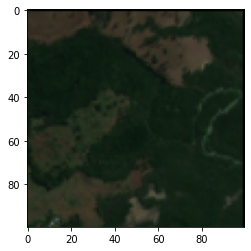

In [21]:
# Plot a random chip to check it looks OK.
pyplot.imshow(get_rgb(train_data[np.random.randint(0, train_data.shape[0]),:,:,:]))

In [19]:
# checking data shapes
train_data.shape, validate_data.shape, test_data.shape

((4258, 100, 100, 3), (533, 100, 100, 3), (535, 100, 100, 3))

In [17]:
# save out numpy arrays for train, validate, test (as can take long to compute data extraction from DEA)
np.save('./train_data', train_data)
np.save('./train_data_labels', train_data_labels)

np.save('./validate_data', validate_data)
np.save('./validate_data_labels', validate_data_labels)

np.save('./test_data', test_data)
np.save('./test_data_labels', test_data_labels)

# # functions for load (FYI)
# train_data = np.load('./train_data.npy')